In [1]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastai.tabular.all as fai_tab
import torch
from torch.utils.data import Dataset, DataLoader

pd.options.display.max_columns = 0

In [2]:
from kaggle import api

comp = "titanic"
path = Path(f"./datasets/{comp}")

if not path.exists():
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    (path/f'{comp}.zip').unlink()

In [3]:
df = pd.read_csv(path/"train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
splits = fai_tab.RandomSplitter(seed=42)(df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [8]:
dls = fai_tab.TabularPandas(df, splits=splits, 
    procs=[fai_tab.Categorify, fai_tab.FillMissing, fai_tab.Normalize],
    cat_names=['Sex', 'Pclass',  'Embarked'],
    cont_names=['Age', 'SibSp', 'Parch', 'Fare'],
    y_names='Survived', y_block=fai_tab.CategoryBlock()
).dataloaders(path=".")

SuggestedLRs(valley=0.02290867641568184)

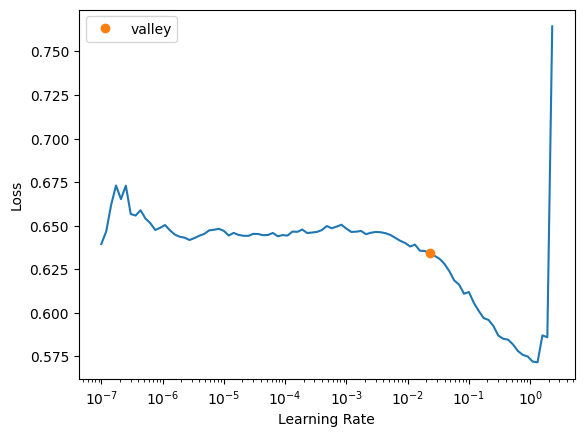

In [9]:
learn = fai_tab.tabular_learner(dls, metrics=fai_tab.accuracy, layers=[10,10])
learn.lr_find()

In [10]:
learn.fit(10, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.583216,0.578522,0.702247,00:00
1,0.523149,0.485109,0.797753,00:00
2,0.485544,0.434760,0.792135,00:00
3,0.464162,0.406739,0.825843,00:00
4,0.451803,0.422440,0.820225,00:00
5,0.446653,0.407321,0.797753,00:00
6,0.444558,0.398824,0.820225,00:00
7,0.438392,0.399724,0.831461,00:00
8,0.434348,0.399584,0.837079,00:00
9,0.428511,0.399754,0.814607,00:00


# Manually

Fastai just does too much for us to be able to effectively experiment with inputs and outputs.

Let's do it all manually with Pytorch.

First, we need to clean and encode the data.

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Fill missing values and Categorify

We're just filling missing values with the median or mode and marking if they were filled.

For categorify, we're one-hot encoding the low cardinality columns and making the high card ones just integers.

In [4]:
def clean_data(df: pd.DataFrame):
    df_clean = df.copy()

    df_clean['Age_missing'] = np.where(
        df_clean['Age'].isna(), 1, 0
    )
    df_clean['Age'] = df_clean['Age'].fillna(df['Age'].median())

    df_clean['Cabin_missing'] = np.where(
        df_clean['Cabin'].isna(), 1, 0
    )
    df_clean['Cabin'] = df_clean['Cabin'].fillna(df['Cabin'].mode().iloc[0])

    df_clean['Embarked_missing'] = np.where(
        df_clean['Embarked'].isna(), 1, 0
    )
    df_clean['Embarked'] = df_clean['Embarked'].fillna(df['Embarked'].mode().iloc[0])

    df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Embarked', 'Pclass'])
    # To simplify normalization, just get the codes
    df_clean['Ticket'] = df_clean['Ticket'].astype('category').cat.codes
    df_clean['Cabin'] = df_clean['Cabin'].astype('category').cat.codes

    # Dropping name for now for simplicity, and passenger id is just a unique value we don't need
    df_clean = df_clean.drop('Name', axis=1)
    df_clean = df_clean.drop('PassengerId', axis=1)
    return df_clean


df_clean = clean_data(df)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Age               891 non-null    float64
 2   SibSp             891 non-null    int64  
 3   Parch             891 non-null    int64  
 4   Ticket            891 non-null    int16  
 5   Fare              891 non-null    float64
 6   Cabin             891 non-null    int16  
 7   Age_missing       891 non-null    int64  
 8   Cabin_missing     891 non-null    int64  
 9   Embarked_missing  891 non-null    int64  
 10  Sex_female        891 non-null    bool   
 11  Sex_male          891 non-null    bool   
 12  Embarked_C        891 non-null    bool   
 13  Embarked_Q        891 non-null    bool   
 14  Embarked_S        891 non-null    bool   
 15  Pclass_1          891 non-null    bool   
 16  Pclass_2          891 non-null    bool   
 1

In [5]:
df_clean.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,A/5 21171,7.2500,B96 B98,0,1,0,False,True,False,False,True
1,1,1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,True,False,True,False,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,0,1,0,True,False,False,False,True
3,1,1,35.0,1,0,113803,53.1000,C123,0,0,0,True,False,False,False,True
4,0,3,35.0,0,0,373450,8.0500,B96 B98,0,1,0,False,True,False,False,True


## Normalize the data

We need to normalize the very high values for the various columns that have values well over single digits like Age and Fare.

This is **extremely** important. I spent a few hours banging my head against the wall trying to figure out why my loss was all over the place and my model wasn't training. Instead of a steady decline in loss as we trained epochs, I was getting a bizarre jagged up/down cycle of loss over time, or sometimes a decrease followed by a spike, and everything in between.

I found an extremely simple version online that basically did the same thing I was doing, but with less data cleaning (just dropped a bunch of columns) that *was* training properly. After running my data through it, I realized that **I did not normalize the columns I had made categorical.** I didn't realize this because `df.describe()` only shows you numeric columns, so `Cabin` and `Ticket`, two high cardinality columns with oridinal numbers going up into the hundreds, were throwing off the training.

After normalizing even the categorical columns, everything trained beautifully.

In [6]:
df_clean.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Age_missing,Cabin_missing,Embarked_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.198653,0.771044,0.002245
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.399210,0.420397,0.047351
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [5]:
def normalize_data(df: pd.DataFrame):
    df_clean = df.copy()
    # Log needs +1 or we get invalid values (can't take log of 0)
    df_clean['Fare'] = np.log(df_clean['Fare'] + 1)

    to_normalize = ['Age', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'Fare']
    for col in to_normalize:
        df_clean[col] = df_clean[col] / df_clean[col].max()
    
    return df_clean

df_clean = normalize_data(df_clean)

## Create dataloaders

Now that we have our data cleaned, we can create dataloaders.

We need tensors, so we convert everything to floats as appropriate.

We also need a train/test split, which we do randomly in this case.

In [6]:
class TitanicDataset(Dataset):
    def __init__(self, df):
        self.label_col = 'Survived'
        self.df = df.copy()

        for col in self.df.columns:
            if isinstance(self.df[col].dtype, pd.CategoricalDtype):
                self.df[col] = self.df[col].cat.codes.astype('float32')
            else:
                self.df[col] = self.df[col].astype('float32')

        self.df_X = torch.from_numpy(self.df.copy().drop('Survived', axis=1).values)
        self.df_y = torch.from_numpy(self.df.copy()['Survived'].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx], self.df_y[idx]

In [7]:
trn_split, val_split = fai_tab.RandomSplitter(seed=42)(df_clean)
# fai_tab.RandomSplitter(seed=42)(df_clean)

# df_clean.iloc[trn_split, :]
ds = TitanicDataset(df_clean)
ds_trn = TitanicDataset(df_clean.iloc[trn_split, :])
ds_val = TitanicDataset(df_clean.iloc[val_split, :])

In [8]:
ds[0]

(tensor([0.2750, 0.1250, 0.0000, 0.7691, 0.3381, 0.3219, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]),
 tensor(0.))

In [9]:
full_dl = DataLoader(ds, batch_size=256)

In [10]:
train_dataloader = DataLoader(ds_trn, batch_size=256, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=256, shuffle=True)

In [11]:
df_clean

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0.2750,0.125,0.000000,0.769118,0.338125,0.321918,0,1,0,False,True,False,False,True,False,False,True
1,1,0.4750,0.125,0.000000,0.876471,0.685892,0.554795,0,0,0,True,False,True,False,False,True,False,False
2,1,0.3250,0.000,0.000000,0.983824,0.350727,0.321918,0,1,0,True,False,False,False,True,False,False,True
3,1,0.4375,0.125,0.000000,0.072059,0.639463,0.376712,0,0,0,True,False,False,False,True,True,False,False
4,0,0.4375,0.000,0.000000,0.694118,0.352955,0.321918,0,1,0,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.3375,0.000,0.000000,0.148529,0.422864,0.321918,0,1,0,False,True,False,False,True,False,True,False
887,1,0.2375,0.000,0.000000,0.020588,0.550238,0.205479,0,0,0,True,False,False,False,True,True,False,False
888,0,0.3500,0.125,0.333333,0.992647,0.512205,0.321918,1,1,0,True,False,False,False,True,False,False,True
889,1,0.3250,0.000,0.000000,0.011765,0.550238,0.410959,0,0,0,False,True,True,False,False,True,False,False


## Train the model

Now that we have dataloaders, we can train a model

tensor(0.8146)


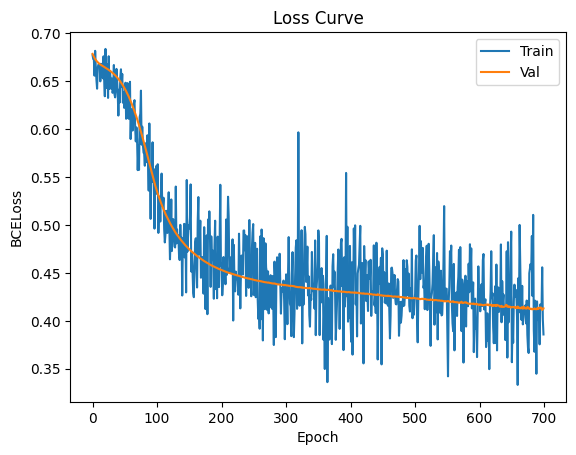

In [17]:
# All but the target column are features
num_features = len(df_clean.columns) - 1
epochs = 700


# More or less replicates fastai's 10, 10, but they seem to have other stuff
# I don't know about yet, like BatchNorm1d and Dropout in addition to  Linear
# So performance will probably be worse, but fine for now
model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.05)
# optim = torch.optim.AdamW(model.parameters(), lr=0.01)

accs = []
losses_trn = []
losses_val = []
def train_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.float().view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()

    loss.backward()
    optim.step()
    optim.zero_grad()

    return loss, acc

def valid_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
    return loss, acc


for epoch in range(epochs):
    model.train()
    for Xb, yb in train_dataloader:
        loss, acc = train_loop(Xb, yb)
    
    losses_trn.append(loss.item())

    model.eval()
    with torch.inference_mode():
        for Xb, yb in val_dataloader:
            loss, acc = valid_loop(Xb, yb)
        
    losses_val.append(loss.item())
    # accs.append(acc)

plt.plot(losses_trn, label='Train')
plt.plot(losses_val, label='Val')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
# plt.plot(accs)
print(acc)

In [64]:
df_test_raw = pd.read_csv(path/"test.csv")
df_test = normalize_data(clean_data(df_test_raw))
df_test

,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.453947,0.000,0.000000,0.419890,0.348997,0.200000,0,1,0,False,True,False,True,False,False,False,True
1,0.618421,0.125,0.000000,0.610497,0.333195,0.200000,0,1,0,True,False,False,False,True,False,False,True
2,0.815789,0.000,0.000000,0.201657,0.379604,0.200000,0,1,0,False,True,False,True,False,False,True,False
3,0.355263,0.000,0.000000,0.406077,0.363449,0.200000,0,1,0,False,True,False,False,True,False,False,True
4,0.289474,0.125,0.111111,0.381215,0.414494,0.200000,0,1,0,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.355263,0.000,0.000000,0.737569,0.352955,0.200000,1,1,0,False,True,False,False,True,False,False,True
414,0.513158,0.000,0.000000,0.895028,0.753026,0.293333,0,0,0,True,False,True,False,False,True,False,False
415,0.506579,0.000,0.000000,0.955801,0.338125,0.200000,0,1,0,False,True,False,False,True,False,False,True
416,0.355263,0.000,0.000000,0.607735,0.352955,0.200000,1,1,0,False,True,False,False,True,False,False,True


In [54]:
class TitanicTestDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()

        for col in self.df.columns:
            if isinstance(self.df[col].dtype, pd.CategoricalDtype):
                self.df[col] = self.df[col].cat.codes.astype('float32')
            else:
                self.df[col] = self.df[col].astype('float32')

        self.df_X = torch.from_numpy(self.df.copy().values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx]

dl_test = DataLoader(
    TitanicTestDataset(df_test)
)

In [72]:
all_preds = []
for x in dl_test:
    preds = model(x)
    all_preds.append(1 if preds.item() > 0.5 else 0)

df_submit = df_test_raw.copy()
df_submit['Survived'] = all_preds

In [73]:
# Got a 77.5% accuracy on the test set
# On validation, got around 83% usually
df_submit[['PassengerId', 'Survived']].to_csv('titanic_test1.csv', index=False)